In [176]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [177]:
import sys
sys.path.append("../scripts")

from train_utils import train_and_validate
from test_model import test_model

Define data transformations

In [178]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Import data

In [179]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [180]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Creation of validation set

In [181]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Data augmentation

In [182]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15, 15)),  # Angolo di rotazione ampliato
    #transforms.RandomAffine(degrees=(-10, 10), shear=(-10, 10), scale=(0.8, 1.2)),  # Shear e zoom aggiunti
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data.dataset.transform = train_transform

Data loader

In [183]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

## Custom CNN

In [184]:
class ThirdCNNWithDropout(nn.Module):
    def __init__(self, dropout_prob_conv=0.1, dropout_prob_fc=0.5):
        super(ThirdCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(dropout_prob_conv)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(dropout_prob_conv)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout2d(dropout_prob_conv)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.dropout4 = nn.Dropout2d(dropout_prob_conv)
        self.relu4 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.dropout_fc = nn.Dropout(dropout_prob_fc)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.dropout3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.dropout4(x)
        x = self.relu4(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 7 * 7)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [185]:
custom_cnn = ThirdCNNWithDropout()

Epoch [1/100], Train Loss: 0.6776, Train Acc: 75.21%, Valid Loss: 0.3939, Valid Acc: 85.22%
Epoch [2/100], Train Loss: 0.4317, Train Acc: 84.24%, Valid Loss: 0.3336, Valid Acc: 87.35%
Epoch [3/100], Train Loss: 0.3698, Train Acc: 86.62%, Valid Loss: 0.2950, Valid Acc: 88.88%
Epoch [4/100], Train Loss: 0.3365, Train Acc: 87.87%, Valid Loss: 0.2706, Valid Acc: 90.10%
Epoch [5/100], Train Loss: 0.3127, Train Acc: 88.69%, Valid Loss: 0.2668, Valid Acc: 90.11%
Epoch [6/100], Train Loss: 0.2969, Train Acc: 89.46%, Valid Loss: 0.2516, Valid Acc: 90.62%
Epoch [7/100], Train Loss: 0.2802, Train Acc: 89.98%, Valid Loss: 0.2353, Valid Acc: 91.38%
Epoch [8/100], Train Loss: 0.2704, Train Acc: 90.28%, Valid Loss: 0.2440, Valid Acc: 91.16%
Epoch [9/100], Train Loss: 0.2631, Train Acc: 90.46%, Valid Loss: 0.2285, Valid Acc: 91.49%
Epoch [10/100], Train Loss: 0.2523, Train Acc: 90.67%, Valid Loss: 0.2277, Valid Acc: 91.60%
Epoch [11/100], Train Loss: 0.2490, Train Acc: 90.98%, Valid Loss: 0.2202, Vali

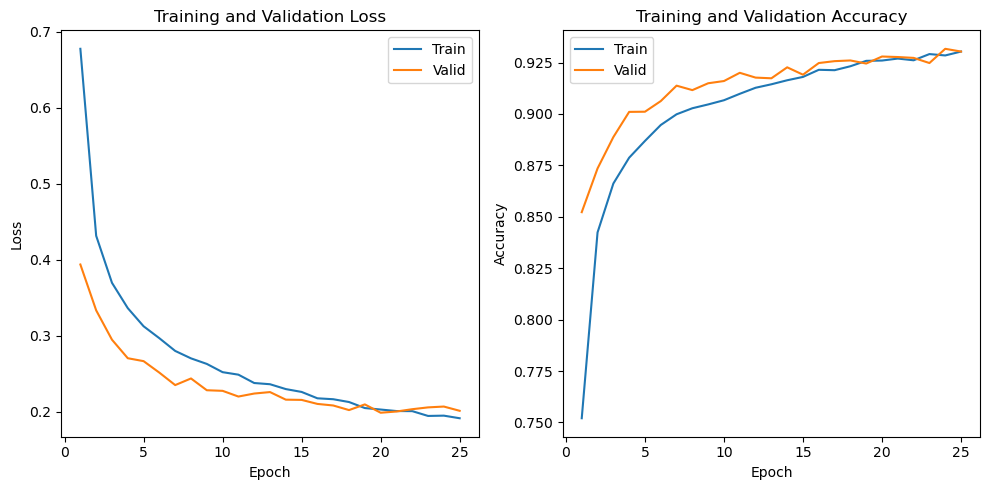

Test Accuracy: 93.01%
Precision: 0.9299
Recall: 0.9301
F1 Score: 0.9296


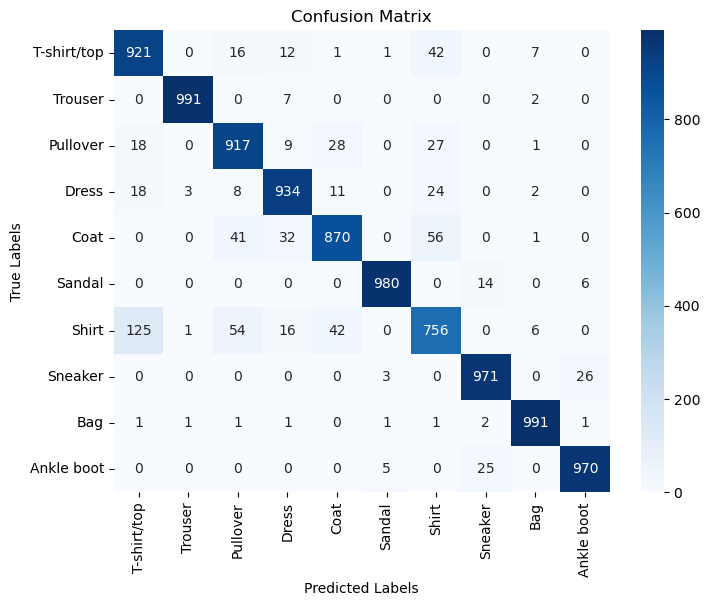

In [186]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=0.001)

train_and_validate(custom_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

test_model(custom_cnn, test_loader, classes, seed=42)

## Pretrained model

In [187]:
class ResNetGray(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetGray, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [188]:
model_resnet = ResNetGray()

d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 0.5901, Train Acc: 78.55%, Valid Loss: 0.5283, Valid Acc: 80.29%
Epoch [2/100], Train Loss: 0.4207, Train Acc: 84.43%, Valid Loss: 0.4104, Valid Acc: 84.43%
Epoch [3/100], Train Loss: 0.3698, Train Acc: 86.39%, Valid Loss: 0.3646, Valid Acc: 86.59%
Epoch [4/100], Train Loss: 0.3432, Train Acc: 87.21%, Valid Loss: 0.3295, Valid Acc: 87.81%
Epoch [5/100], Train Loss: 0.3194, Train Acc: 88.18%, Valid Loss: 0.3395, Valid Acc: 87.44%
Epoch [6/100], Train Loss: 0.3025, Train Acc: 88.74%, Valid Loss: 0.3101, Valid Acc: 88.22%
Epoch [7/100], Train Loss: 0.2867, Train Acc: 89.39%, Valid Loss: 0.3109, Valid Acc: 88.11%
Epoch [8/100], Train Loss: 0.2788, Train Acc: 89.61%, Valid Loss: 0.2848, Valid Acc: 89.25%
Epoch [9/100], Train Loss: 0.2669, Train Acc: 90.00%, Valid Loss: 0.2929, Valid Acc: 88.98%
Epoch [10/100], Train Loss: 0.2575, Train Acc: 90.54%, Valid Loss: 0.2838, Valid Acc: 89.50%
Epoch [11/100], Train Loss: 0.2493, Train Acc: 90.63%, Valid Loss: 0.2728, Vali

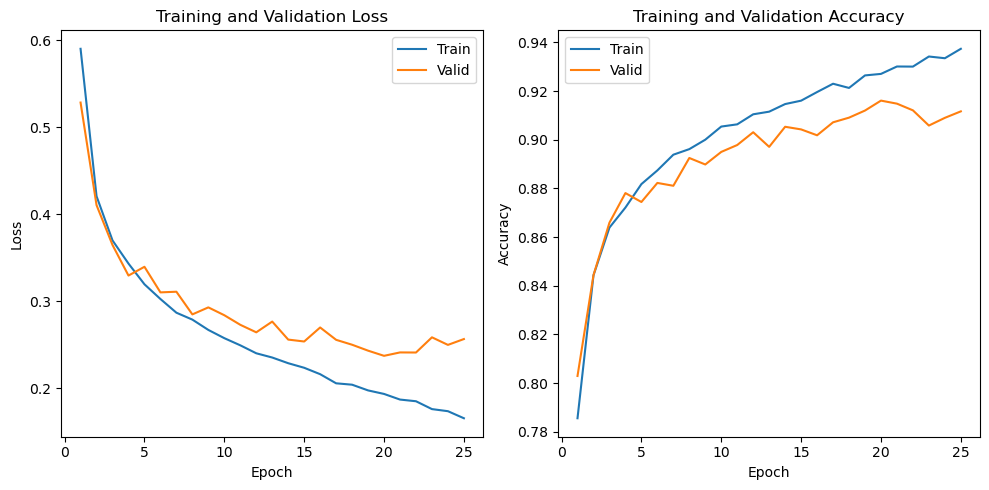

Test Accuracy: 91.27%
Precision: 0.9129
Recall: 0.9127
F1 Score: 0.9122


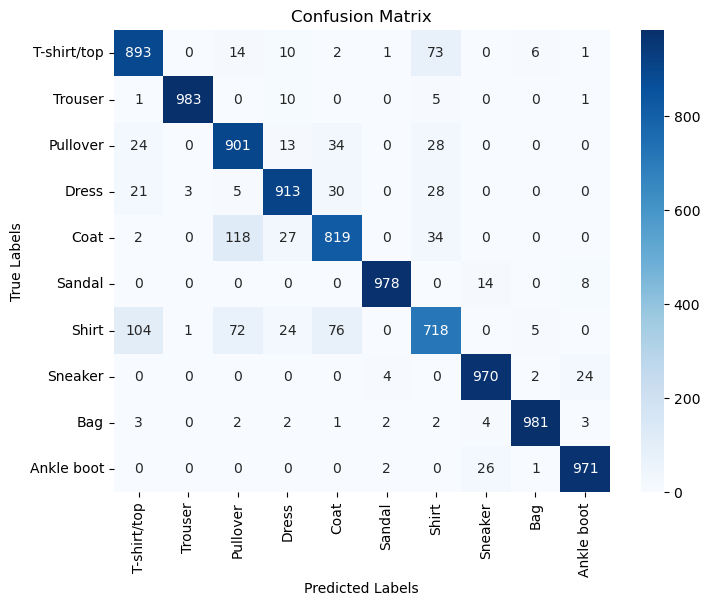

In [189]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

train_and_validate(model_resnet, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

test_model(model_resnet, test_loader, classes, seed=42)

Prove a caso

d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 0.6977, Train Acc: 74.50%, Valid Loss: 0.5108, Valid Acc: 81.06%
Epoch [2/100], Train Loss: 0.5261, Train Acc: 80.71%, Valid Loss: 0.4408, Valid Acc: 83.80%
Epoch [3/100], Train Loss: 0.4677, Train Acc: 82.37%, Valid Loss: 0.3621, Valid Acc: 86.88%
Epoch [4/100], Train Loss: 0.4413, Train Acc: 83.16%, Valid Loss: 0.3394, Valid Acc: 87.15%
Epoch [5/100], Train Loss: 0.4146, Train Acc: 84.18%, Valid Loss: 0.3201, Valid Acc: 88.17%
Epoch [6/100], Train Loss: 0.4024, Train Acc: 84.60%, Valid Loss: 0.3459, Valid Acc: 87.57%
Epoch [7/100], Train Loss: 0.3823, Train Acc: 85.06%, Valid Loss: 0.3117, Valid Acc: 88.44%
Epoch [8/100], Train Loss: 0.3659, Train Acc: 85.66%, Valid Loss: 0.2986, Valid Acc: 89.28%
Epoch [9/100], Train Loss: 0.3623, Train Acc: 85.93%, Valid Loss: 0.2987, Valid Acc: 88.89%
Epoch [10/100], Train Loss: 0.3467, Train Acc: 86.55%, Valid Loss: 0.2801, Valid Acc: 89.84%
Epoch [11/100], Train Loss: 0.3403, Train Acc: 86.67%, Valid Loss: 0.2659, Vali

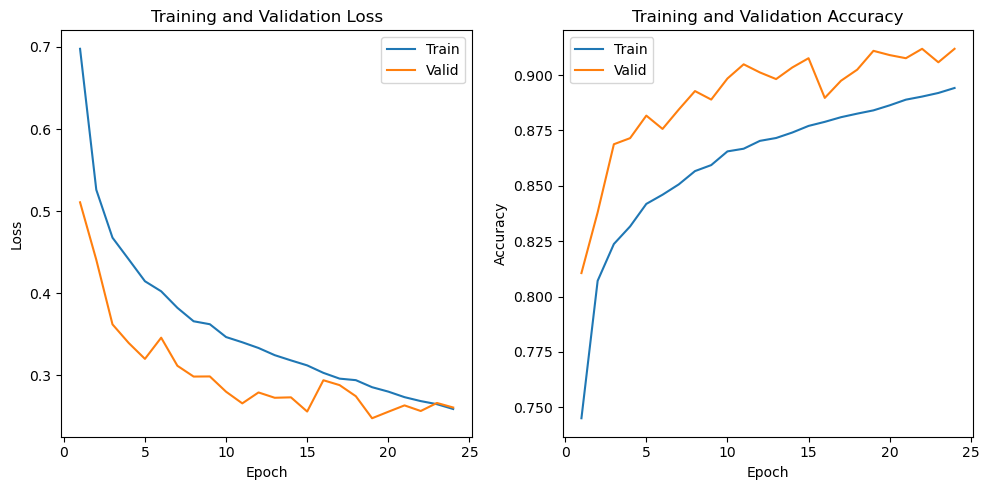

Test Accuracy: 91.52%
Precision: 0.9155
Recall: 0.9152
F1 Score: 0.9147


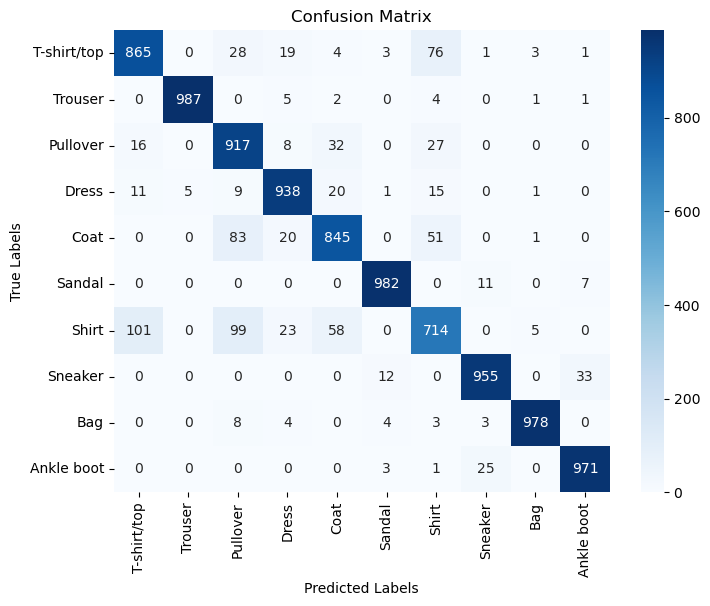

In [190]:
#best modified model
class ResnetGrayImproved(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.1):
        super(ResnetGrayImproved, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x
    
model_improv03 = ResnetGrayImproved()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_improv03.parameters(), lr=0.001)

train_and_validate(model_improv03, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

test_model(model_improv03, test_loader, classes, seed=42)

d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 0.5881, Train Acc: 78.56%, Valid Loss: 0.5622, Valid Acc: 79.12%
Epoch [2/100], Train Loss: 0.4210, Train Acc: 84.56%, Valid Loss: 0.3997, Valid Acc: 84.76%
Epoch [3/100], Train Loss: 0.3712, Train Acc: 86.19%, Valid Loss: 0.3527, Valid Acc: 87.29%
Epoch [4/100], Train Loss: 0.3443, Train Acc: 87.28%, Valid Loss: 0.3391, Valid Acc: 87.27%
Epoch [5/100], Train Loss: 0.3227, Train Acc: 88.09%, Valid Loss: 0.3444, Valid Acc: 87.59%
Epoch [6/100], Train Loss: 0.3038, Train Acc: 88.66%, Valid Loss: 0.3163, Valid Acc: 88.11%
Epoch [7/100], Train Loss: 0.2929, Train Acc: 89.22%, Valid Loss: 0.3000, Valid Acc: 88.73%
Epoch [8/100], Train Loss: 0.2789, Train Acc: 89.71%, Valid Loss: 0.2871, Valid Acc: 89.36%
Epoch [9/100], Train Loss: 0.2719, Train Acc: 89.87%, Valid Loss: 0.2975, Valid Acc: 89.08%
Epoch [10/100], Train Loss: 0.2588, Train Acc: 90.48%, Valid Loss: 0.2786, Valid Acc: 89.80%
Epoch [11/100], Train Loss: 0.2518, Train Acc: 90.75%, Valid Loss: 0.2742, Vali

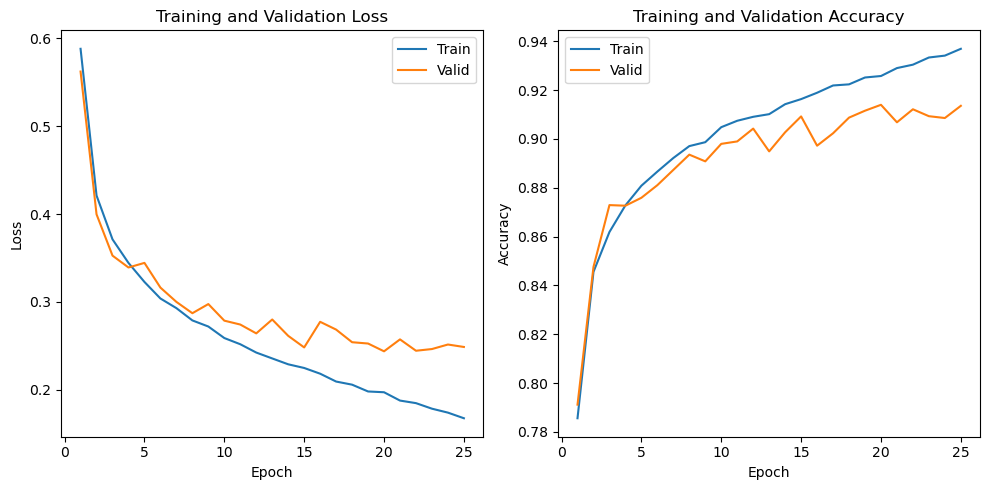

Test Accuracy: 91.71%
Precision: 0.9166
Recall: 0.9171
F1 Score: 0.9164


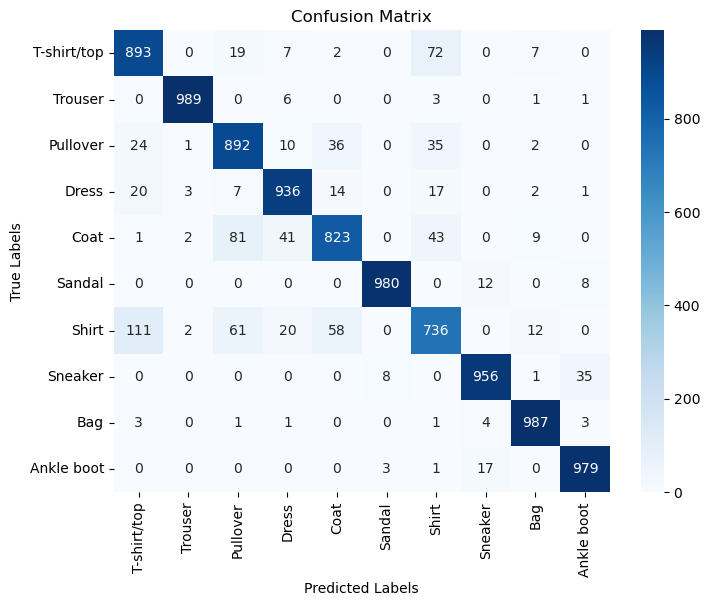

In [191]:
class ResNetGrayImproved(nn.Module):
    def __init__(self, num_classes=10, l2_penalty=0.01):
        super(ResNetGrayImproved, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        self.l2_penalty = l2_penalty

    def forward(self, x):
        x = self.resnet(x)
        # L2 regularization
        l2_reg = torch.tensor(0., device=x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        return x + self.l2_penalty * l2_reg
    
model_l2 = ResNetGrayImproved()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_l2.parameters(), lr=0.001)

train_and_validate(model_l2, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

test_model(model_l2, test_loader, classes, seed=42)

d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 0.7426, Train Acc: 72.66%, Valid Loss: 0.5985, Valid Acc: 77.82%
Epoch [2/100], Train Loss: 0.6055, Train Acc: 77.37%, Valid Loss: 0.5633, Valid Acc: 78.69%
Epoch [3/100], Train Loss: 0.5654, Train Acc: 78.93%, Valid Loss: 0.5362, Valid Acc: 79.92%
Epoch [4/100], Train Loss: 0.5400, Train Acc: 79.83%, Valid Loss: 0.5220, Valid Acc: 80.65%
Epoch [5/100], Train Loss: 0.5269, Train Acc: 80.34%, Valid Loss: 0.5049, Valid Acc: 81.45%
Epoch [6/100], Train Loss: 0.5159, Train Acc: 80.76%, Valid Loss: 0.5021, Valid Acc: 81.01%
Epoch [7/100], Train Loss: 0.5052, Train Acc: 80.94%, Valid Loss: 0.5117, Valid Acc: 81.03%
Epoch [8/100], Train Loss: 0.4972, Train Acc: 81.25%, Valid Loss: 0.4868, Valid Acc: 81.80%
Epoch [9/100], Train Loss: 0.4897, Train Acc: 81.52%, Valid Loss: 0.4973, Valid Acc: 81.29%
Epoch [10/100], Train Loss: 0.4812, Train Acc: 82.04%, Valid Loss: 0.4878, Valid Acc: 81.97%
Epoch [11/100], Train Loss: 0.4781, Train Acc: 81.97%, Valid Loss: 0.4768, Vali

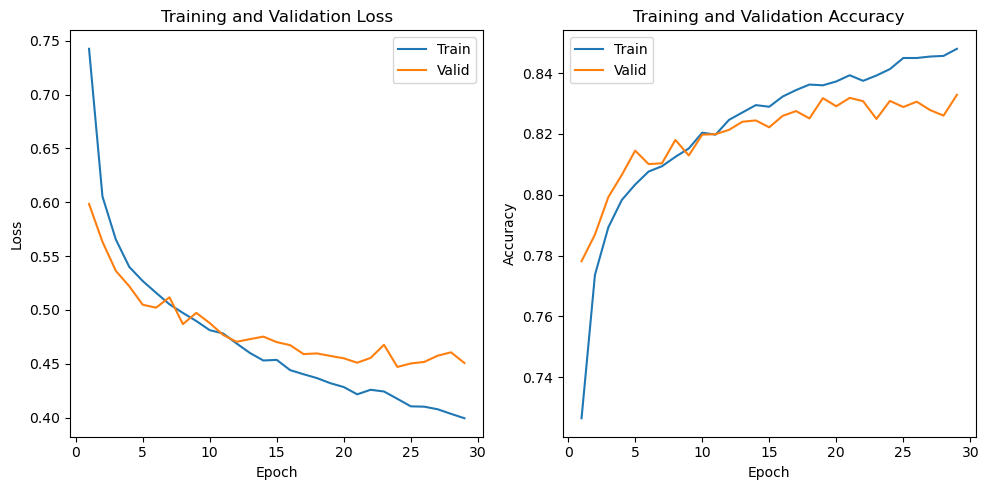

Test Accuracy: 83.44%
Precision: 0.8343
Recall: 0.8344
F1 Score: 0.8341


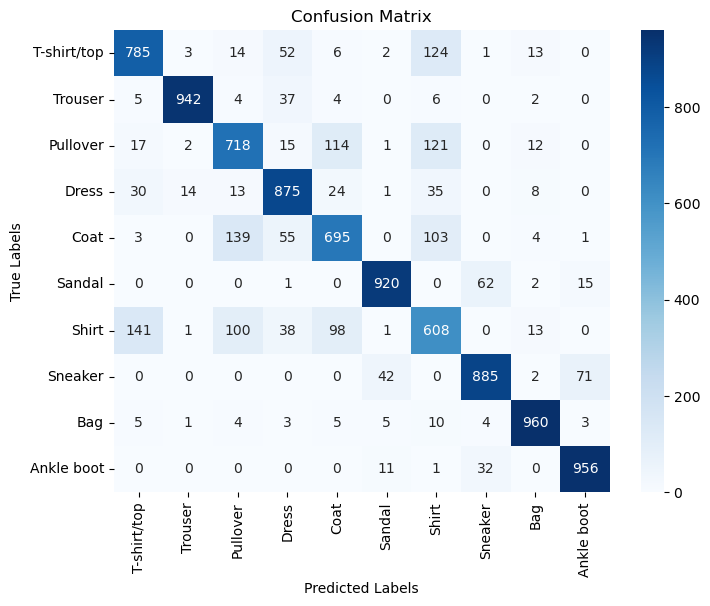

In [192]:
# partial fine-tuning
class PartialFineTunedResNetGray(nn.Module):
    def __init__(self, num_classes=10, num_trainable_layers=5):
        super(PartialFineTunedResNetGray, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Congela tutti gli strati
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Abilita il fine-tuning solo per gli ultimi strati
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        # Sostituisci l'ultimo strato completamente connesso per l'adattamento al numero di classi
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)
    
model_partial_fine_tuned = PartialFineTunedResNetGray()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_partial_fine_tuned.parameters(), lr=0.001)

train_and_validate(model_partial_fine_tuned, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

test_model(model_partial_fine_tuned, test_loader, classes, seed=42)